**import libraries**

In [241]:
import pandas as pd
from matplotlib import pyplot
from tensorflow.keras.utils import plot_model
import re
import pickle
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from keras.layers import Dense, Input, Embedding, LSTM, Conv1D, Dropout, MaxPooling1D, BatchNormalization, Bidirectional, GlobalMaxPooling1D, Flatten

In [71]:
!pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [80]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [93]:
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords

### **Read Dataset**

In [2]:
!gdown --id 1XulBQYyiPRXMpwfm-RIvaDLCLDKIU6UD

/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1XulBQYyiPRXMpwfm-RIvaDLCLDKIU6UD
To: /content/review_10_product_women.csv
100% 9.48M/9.48M [00:00<00:00, 24.5MB/s]


In [17]:
df = pd.read_csv('/content/review_10_product_women.csv')

In [18]:
df.head()

,stars,title,body
0,4.0 out of 5 stars,Short people and big booty Judy’s.,Honest review would be more like a 4.5. Issue ...
1,4.0 out of 5 stars,Great Pants,I LOVE these pants! I originally bought 2x bec...
2,5.0 out of 5 stars,Kinda big,I usually wear a medium however this was close...
3,5.0 out of 5 stars,OMG I love these pants.,They feel so good and smooth. Great if you are...
4,4.0 out of 5 stars,"Nice, but large","These are comfortable, but as others have ment..."


In [19]:
df.shape

(49802, 3)

### **Prepare** Dataset

In [20]:
df['star'] = df['stars'].apply(lambda x: str(x).split()[0]).astype(float)

In [21]:
df.head(3)

,stars,title,body,star
0,4.0 out of 5 stars,Short people and big booty Judy’s.,Honest review would be more like a 4.5. Issue ...,4.0
1,4.0 out of 5 stars,Great Pants,I LOVE these pants! I originally bought 2x bec...,4.0
2,5.0 out of 5 stars,Kinda big,I usually wear a medium however this was close...,5.0


In [22]:
df['sentiment'] = df['star'].apply(lambda x: 1 if x >= 3 else 0)

In [23]:
df.head(3)

,stars,title,body,star,sentiment
0,4.0 out of 5 stars,Short people and big booty Judy’s.,Honest review would be more like a 4.5. Issue ...,4.0,1
1,4.0 out of 5 stars,Great Pants,I LOVE these pants! I originally bought 2x bec...,4.0,1
2,5.0 out of 5 stars,Kinda big,I usually wear a medium however this was close...,5.0,1


In [24]:
df['sentiment'].unique()

array([1, 0])

In [25]:
df['sentiment'].value_counts()

1    45180
0     4622
Name: sentiment, dtype: int64

In [42]:
positive = df[(df['sentiment'] == 1)]
negative = df[(df['sentiment'] == 0)]

In [43]:
print(positive.shape)
print(negative.shape)

(45180, 5)
(4622, 5)


In [44]:
positive_sample = positive.sample(n=8000, replace=True, random_state=50)

In [45]:
print(positive_sample.shape)
print(negative.shape)

(8000, 5)
(4622, 5)


In [46]:
data = pd.concat([positive_sample, negative], axis=0)

In [47]:
data.shape

(12622, 5)

In [49]:
data.tail()

,stars,title,body,star,sentiment
49795,1.0 out of 5 stars,Not good quality. Chinese low quality,Not flattering at all made me look huge and I ...,1.0,0
49796,2.0 out of 5 stars,Cute but too big,Way too big! And I got the smallest size. I’m ...,2.0,0
49797,2.0 out of 5 stars,Did not like high neck,No shape to the dress which was fine but not s...,2.0,0
49799,2.0 out of 5 stars,TOO SMALL,NOT TRUE TO FIT,2.0,0
49801,1.0 out of 5 stars,Feels cheap.,"Material feels thin, cheap and itchy. Definite...",1.0,0


### **Preprocessing**

In [68]:
bodies = data['body'].values
titles = data['title'].values
y = data['sentiment'].values

In [69]:
sentences = [(str(t)+' '+str(b)) for t,b in zip(titles,bodies)]

In [70]:
sentences[0]

'Great basics I have purchased a few pairs of these shorts, they look good, hold up, and are very affordable. They have apocket too so you can carry your phone or a mask easy! They are great basic shorts.'

In [101]:
tokenizer = RegexpTokenizer(r'\w+')
sentences_tokenize = [tokenizer.tokenize(s.lower()) for s in sentences]

In [102]:
sentences_tokenize[0]

['great',
 'basics',
 'i',
 'have',
 'purchased',
 'a',
 'few',
 'pairs',
 'of',
 'these',
 'shorts',
 'they',
 'look',
 'good',
 'hold',
 'up',
 'and',
 'are',
 'very',
 'affordable',
 'they',
 'have',
 'apocket',
 'too',
 'so',
 'you',
 'can',
 'carry',
 'your',
 'phone',
 'or',
 'a',
 'mask',
 'easy',
 'they',
 'are',
 'great',
 'basic',
 'shorts']

In [105]:
stopwords = set(stopwords.words("english"))

AttributeError: ignored

In [106]:
len(stopwords)

179

In [110]:
sentences_tokenize_filtered = [[w for w in sentence if w not in stopwords] for sentence in sentences_tokenize]

In [111]:
sentences_tokenize_filtered[5]

['great',
 'pair',
 'pants',
 'good',
 'fit',
 'super',
 'comfortable',
 '1st',
 'pair',
 'skinny',
 'tried',
 'really',
 'liked']

In [119]:
corpus = []
for sentence in sentences_tokenize_filtered:
  s = ''
  for w in sentence:
    s += w + ' '
  corpus.append(s) 

In [120]:
corpus[5]

'great pair pants good fit super comfortable 1st pair skinny tried really liked '

**keras Tokenizer**

In [123]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)

In [126]:
with open('tokenizer.h5', 'wb') as f:
    pickle.dump(tokenizer, f)

In [127]:
vocab_size = len(tokenizer.word_index)+1

In [175]:
vocab_size

8734

In [151]:
def max_length(tensor):
    return max(len(t) for t in tensor)

In [152]:
data_to_sequences = tokenizer.texts_to_sequences(corpus)

In [155]:
maxlen = max_length(data_to_sequences)
maxlen

326

In [130]:
data_to_sequences[5]

[6, 75, 42, 17, 1, 32, 7, 1073, 75, 194, 189, 35, 168]

In [144]:
pad_data_to_sequences = pad_sequences(data_to_sequences, maxlen=50)

In [248]:
pad_data_to_sequences[5]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    6,   75,   42,   17,    1,   32,    7,
       1073,   75,  194,  189,   35,  168], dtype=int32)

In [172]:
print(pad_data_to_sequences.shape)
print(y.shape)

(12622, 50)
(12622,)


In [173]:
X_train, X_test, y_train, y_test = train_test_split(pad_data_to_sequences, y, test_size=0.3, random_state=50)

In [174]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(8835, 50)
(3787, 50)
(8835,)
(3787,)


## **Neural Networks**

### **CNN Model**

In [243]:
i = Input(shape=(50,))
x = Embedding(vocab_size, 50, input_length=50)(i)
x = Conv1D(32, 5, padding='same', activation='relu')(x)
x = Dropout(0.3)(x)
x = MaxPooling1D(2)(x)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)

In [244]:
model = Model(i, x)

In [245]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [246]:
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 50)]              0         
                                                                 
 embedding_10 (Embedding)    (None, 50, 50)            436700    
                                                                 
 conv1d_8 (Conv1D)           (None, 50, 32)            8032      
                                                                 
 dropout_22 (Dropout)        (None, 50, 32)            0         
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 25, 32)           0         
 1D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 800)               0         
                                                           

In [247]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=7, batch_size=128)

Epoch 1/7
70/70 [==============================] - 3s 35ms/step - loss: 0.6040 - accuracy: 0.6701 - val_loss: 0.4183 - val_accuracy: 0.8260
Epoch 2/7
70/70 [==============================] - 2s 32ms/step - loss: 0.3180 - accuracy: 0.8647 - val_loss: 0.3303 - val_accuracy: 0.8569
Epoch 3/7
70/70 [==============================] - 2s 33ms/step - loss: 0.2310 - accuracy: 0.9115 - val_loss: 0.3278 - val_accuracy: 0.8595
Epoch 4/7
70/70 [==============================] - 2s 32ms/step - loss: 0.1902 - accuracy: 0.9319 - val_loss: 0.3424 - val_accuracy: 0.8611
Epoch 5/7
70/70 [==============================] - 2s 32ms/step - loss: 0.1629 - accuracy: 0.9433 - val_loss: 0.3649 - val_accuracy: 0.8590
Epoch 6/7
70/70 [==============================] - 2s 32ms/step - loss: 0.1327 - accuracy: 0.9559 - val_loss: 0.4058 - val_accuracy: 0.8571
Epoch 7/7
70/70 [==============================] - 2s 33ms/step - loss: 0.1148 - accuracy: 0.9640 - val_loss: 0.4330 - val_accuracy: 0.8482


### **LSTM Model**

In [214]:
i = Input(shape=(50,))
x = Embedding(vocab_size, 50, input_length=50)(i)
x = Bidirectional(LSTM(128,return_sequences=True))(x)
x = LSTM(64)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)

In [215]:
model = Model(i, x)

In [216]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [217]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding_3 (Embedding)     (None, 50, 50)            436700    
                                                                 
 bidirectional_3 (Bidirectio  (None, 50, 256)          183296    
 nal)                                                            
                                                                 
 lstm_7 (LSTM)               (None, 64)                82176     
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                           

In [218]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=7, batch_size=128)

Epoch 1/7
70/70 [==============================] - 97s 533ms/step - loss: 0.5185 - accuracy: 0.7371 - val_loss: 0.3490 - val_accuracy: 0.8490
Epoch 2/7
70/70 [==============================] - 35s 497ms/step - loss: 0.2857 - accuracy: 0.8861 - val_loss: 0.3269 - val_accuracy: 0.8643
Epoch 3/7
70/70 [==============================] - 36s 511ms/step - loss: 0.2194 - accuracy: 0.9179 - val_loss: 0.3569 - val_accuracy: 0.8553
Epoch 4/7
70/70 [==============================] - 35s 499ms/step - loss: 0.1819 - accuracy: 0.9338 - val_loss: 0.3829 - val_accuracy: 0.8545
Epoch 5/7
70/70 [==============================] - 35s 500ms/step - loss: 0.1609 - accuracy: 0.9400 - val_loss: 0.4464 - val_accuracy: 0.8524
Epoch 6/7
70/70 [==============================] - 35s 502ms/step - loss: 0.1411 - accuracy: 0.9493 - val_loss: 0.5052 - val_accuracy: 0.8426
Epoch 7/7
70/70 [==============================] - 36s 521ms/step - loss: 0.1150 - accuracy: 0.9583 - val_loss: 0.4672 - val_accuracy: 0.8437


In [219]:
scores = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

119/119 [==============================] - 8s 63ms/step - loss: 0.4672 - accuracy: 0.8437
Accuracy: 84.37%


### **CNN-LSTM Model**

In [249]:
i = Input(shape=(50,))
x = Embedding(vocab_size, 50, input_length=50)(i)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Conv1D(32, 5, padding='same', activation='relu')(x)
x = Dropout(0.3)(x)
x = MaxPooling1D(2)(x)
x = Bidirectional(LSTM(128,return_sequences=True))(x)
x = LSTM(64)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)

In [250]:
model = Model(i, x)

In [251]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [252]:
model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 50)]              0         
                                                                 
 embedding_11 (Embedding)    (None, 50, 50)            436700    
                                                                 
 batch_normalization_4 (Batc  (None, 50, 50)           200       
 hNormalization)                                                 
                                                                 
 dropout_24 (Dropout)        (None, 50, 50)            0         
                                                                 
 conv1d_9 (Conv1D)           (None, 50, 32)            8032      
                                                                 
 dropout_25 (Dropout)        (None, 50, 32)            0         
                                                           

In [253]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=128)

Epoch 1/10
70/70 [==============================] - 29s 325ms/step - loss: 0.4936 - accuracy: 0.7485 - val_loss: 0.6285 - val_accuracy: 0.8542
Epoch 2/10
70/70 [==============================] - 19s 271ms/step - loss: 0.3001 - accuracy: 0.8807 - val_loss: 0.6094 - val_accuracy: 0.8072
Epoch 3/10
70/70 [==============================] - 19s 270ms/step - loss: 0.2429 - accuracy: 0.9076 - val_loss: 0.5516 - val_accuracy: 0.8328
Epoch 4/10
70/70 [==============================] - 19s 271ms/step - loss: 0.2079 - accuracy: 0.9242 - val_loss: 0.4584 - val_accuracy: 0.8497
Epoch 5/10
70/70 [==============================] - 19s 273ms/step - loss: 0.1775 - accuracy: 0.9356 - val_loss: 0.4027 - val_accuracy: 0.8455
Epoch 6/10
70/70 [==============================] - 19s 277ms/step - loss: 0.1615 - accuracy: 0.9398 - val_loss: 0.3612 - val_accuracy: 0.8569
Epoch 7/10
70/70 [==============================] - 19s 278ms/step - loss: 0.1548 - accuracy: 0.9459 - val_loss: 0.3522 - val_accuracy: 0.8474

In [185]:
scores = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

119/119 [==============================] - 8s 68ms/step - loss: 0.3486 - accuracy: 0.8513
Accuracy: 85.13%


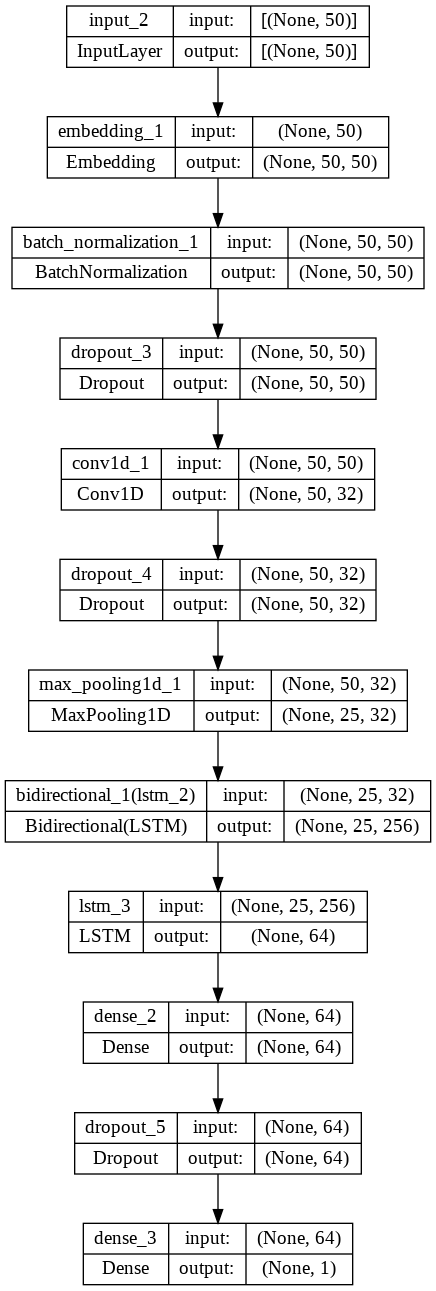

In [188]:
plot_model(model, show_shapes=True)

In [189]:
def plot_graphs(history, string):
    pyplot.plot(history.history[string])
    pyplot.plot(history.history['val_'+string])
    pyplot.xlabel("Epochs")
    pyplot.ylabel(string)
    pyplot.legend([string, 'val_'+string])
    pyplot.show()

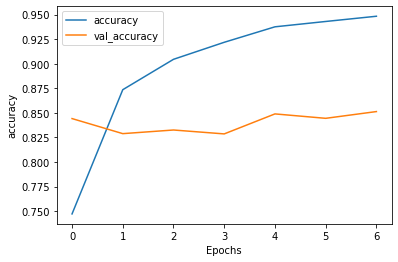

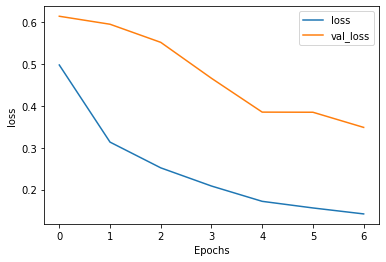

In [190]:
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [203]:
def prediction(sentence):
  data = tokenizer.texts_to_sequences([sentence])
  data_pad_sequence = pad_sequences(data, maxlen=50)
  perdiction = model.predict(data_pad_sequence)
  print(perdiction[0])
  if perdiction[0][0] > 0.5:
    return "positive"
  else: 
    return "negative" 